# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В нашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Нам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.


**Описание данных**

Признаки

•	`DateCrawled` — дата скачивания анкеты из базы

•	`VehicleType` — тип автомобильного кузова

•	`RegistrationYear` — год регистрации автомобиля

•	`Gearbox` — тип коробки передач

•	`Power` — мощность (л. с.)

•	`Model` — модель автомобиля

•	`Kilometer` — пробег (км)

•	`RegistrationMonth` — месяц регистрации автомобиля

•	`FuelType` — тип топлива

•	`Brand` — марка автомобиля

•	`Repaired` — была машина в ремонте или нет

•	`DateCreated` — дата создания анкеты

•	`NumberOfPictures` — количество фотографий автомобиля

•	`PostalCode` — почтовый индекс владельца анкеты (пользователя)

•	`LastSeen` — дата последней активности пользователя

Целевой признак

`Price` — цена (евро)


## Подготовка данных

### Загрузка библиотек и данных для проекта

In [1]:
# делаем необходимые установки
!pip install lightgbm -q
!pip install phik -q

In [2]:
# обновляем библиотеки
!pip install scikit-learn --upgrade -q
!pip install pandas --upgrade -q
!pip install scipy --upgrade -q
!pip install numba --upgrade -q
!pip install numpy==1.26.4 -q
!pip install matplotlib --upgrade -q
!pip install seaborn --upgrade -q

In [3]:
# загружаем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as st
import re
import os
import time

import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import root_mean_squared_error
from sklearn.preprocessing import OneHotEncoder, TargetEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.dummy import DummyRegressor
from sklearn.pipeline import Pipeline

import lightgbm as lgb
from lightgbm import LGBMRegressor

import phik
from phik import phik_matrix
from phik.report import plot_correlation_matrix

In [4]:
# задаем константы
RANDOM_STATE = 12345
TEST_SIZE = 0.25

In [5]:
# загружаем данные в датафрейм
path_1 = 'https://code.s3.yandex.net/datasets/autos.csv'
path_2 = '/datasets/autos.csv'
if os.path.exists(path_1):
    auto_data = pd.read_csv(path_1)
elif os.path.exists(path_2):
    auto_data = pd.read_csv(path_2)
else:
    print('Something is wrong')

In [6]:
# выводим общую информацию по датафрейму
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

### Предобработка данных 

In [7]:
# сделаем необходимые переименования столбцов в датафрейме, приведем их к змеиному регистру
auto_data.columns = [re.sub(r'(?<!^)(?=[A-Z])|(\s+)', '_', i).lower()
                     for i in auto_data.columns]

In [8]:
# смотрим результат сделанных изменений
auto_data.head()

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [9]:
# проверяем датафрейм на наличие явных дупликатов
auto_data.duplicated().sum()

4

In [10]:
# удаляем дупликаты
auto_data = auto_data.drop_duplicates()

In [11]:
# смотрим все уникальные значения по категориальному признаку 'vehicle_type'
# проверяем на наличие неявных дупликатов
auto_data['vehicle_type'].sort_values().unique()

array(['bus', 'convertible', 'coupe', 'other', 'sedan', 'small', 'suv',
       'wagon', nan], dtype=object)

In [12]:
# смотрим все уникальные значения по категориальному признаку 'gearbox', проверяем на наличие неявных дупликатов
auto_data['gearbox'].sort_values().unique()

array(['auto', 'manual', nan], dtype=object)

In [13]:
# смотрим все уникальные значения по категориальному признаку 'fuel_type', проверяем на наличие неявных дупликатов
auto_data['fuel_type'].sort_values().unique()

array(['cng', 'electric', 'gasoline', 'hybrid', 'lpg', 'other', 'petrol',
       nan], dtype=object)

In [14]:
# смотрим все уникальные значения по категориальному признаку 'model', проверяем на наличие неявных дупликатов
auto_data['model'].sort_values().unique()

array(['100', '145', '147', '156', '159', '1_reihe', '1er', '200',
       '2_reihe', '300c', '3_reihe', '3er', '4_reihe', '500', '5_reihe',
       '5er', '601', '6_reihe', '6er', '7er', '80', '850', '90', '900',
       '9000', '911', 'a1', 'a2', 'a3', 'a4', 'a5', 'a6', 'a8',
       'a_klasse', 'accord', 'agila', 'alhambra', 'almera', 'altea',
       'amarok', 'antara', 'arosa', 'astra', 'auris', 'avensis', 'aveo',
       'aygo', 'b_klasse', 'b_max', 'beetle', 'berlingo', 'bora',
       'boxster', 'bravo', 'c1', 'c2', 'c3', 'c4', 'c5', 'c_klasse',
       'c_max', 'c_reihe', 'caddy', 'calibra', 'captiva', 'carisma',
       'carnival', 'cayenne', 'cc', 'ceed', 'charade', 'cherokee',
       'citigo', 'civic', 'cl', 'clio', 'clk', 'clubman', 'colt', 'combo',
       'cooper', 'cordoba', 'corolla', 'corsa', 'cr_reihe', 'croma',
       'crossfire', 'cuore', 'cx_reihe', 'defender', 'delta', 'discovery',
       'doblo', 'ducato', 'duster', 'e_klasse', 'elefantino', 'eos',
       'escort', 'espac

In [15]:
# смотрим все уникальные значения по категориальному признаку 'brand'
# проверяем на наличие неявных дупликатов
auto_data['brand'].sort_values().unique()

array(['alfa_romeo', 'audi', 'bmw', 'chevrolet', 'chrysler', 'citroen',
       'dacia', 'daewoo', 'daihatsu', 'fiat', 'ford', 'honda', 'hyundai',
       'jaguar', 'jeep', 'kia', 'lada', 'lancia', 'land_rover', 'mazda',
       'mercedes_benz', 'mini', 'mitsubishi', 'nissan', 'opel', 'peugeot',
       'porsche', 'renault', 'rover', 'saab', 'seat', 'skoda', 'smart',
       'sonstige_autos', 'subaru', 'suzuki', 'toyota', 'trabant',
       'volkswagen', 'volvo'], dtype=object)

In [16]:
# смотрим все уникальные значения по категориальному признаку 'repaired'
# проверяем на наличие неявных дупликатов
auto_data['repaired'].sort_values().unique()

array(['no', 'yes', nan], dtype=object)

**Вывод:** Проверка на наличие неявных дубликатов закончена, мы не выявили неявных дубликатов. На следующем шаге мы будем заполнять пропуски в данных.


In [17]:
# заполняем все пропуски по категориальному признаку 'model'
model = auto_data.groupby('brand')['model'].transform(lambda x: x.mode()[0]
                                                      if not x.mode().empty else 'unknown')
auto_data['model'] = auto_data['model'].fillna(model)

# проверяем, остались ли пропуски
print('Число пропусков в model:', auto_data['model'].isna().sum())

Число пропусков в model: 0


In [18]:
# заполняем пропуски в категориальных признаках 'vehicle_type', 'gearbox', 'fuel_type'
fill = auto_data.groupby('model')[['vehicle_type', 'gearbox',
                                   'fuel_type']].transform(lambda x: x.mode()[0]
                                                           if not x.mode().empty else 'unknown') 

auto_data['vehicle_type'] = auto_data['vehicle_type'].fillna(fill['vehicle_type'])
auto_data['fuel_type'] = auto_data['fuel_type'].fillna(fill['fuel_type'])
auto_data['gearbox'] = auto_data['gearbox'].fillna(fill['gearbox'])

# проверяем, остались ли пропуски
print('Число пропусков в vehicle_type:', auto_data['vehicle_type'].isna().sum())
print('Число пропусков в gearbox:', auto_data['gearbox'].isna().sum())
print('Число пропусков в fuel_type:', auto_data['fuel_type'].isna().sum())

Число пропусков в vehicle_type: 0
Число пропусков в gearbox: 0
Число пропусков в fuel_type: 0


In [19]:
# заполняем пропуски по признаку 'repaired' значениями 'no information'
auto_data['repaired'] = auto_data['repaired'].fillna('no information')
print(auto_data['repaired'].value_counts())

# проверяем, остались ли пропуски
print('Число пропусков в repaired:', auto_data['repaired'].isna().sum())

repaired
no                247158
no information     71154
yes                36053
Name: count, dtype: int64
Число пропусков в repaired: 0


In [20]:
# мы заполнили все пропуски, выводим общую информацию по датафрейму
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354365 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   date_crawled        354365 non-null  object
 1   price               354365 non-null  int64 
 2   vehicle_type        354365 non-null  object
 3   registration_year   354365 non-null  int64 
 4   gearbox             354365 non-null  object
 5   power               354365 non-null  int64 
 6   model               354365 non-null  object
 7   kilometer           354365 non-null  int64 
 8   registration_month  354365 non-null  int64 
 9   fuel_type           354365 non-null  object
 10  brand               354365 non-null  object
 11  repaired            354365 non-null  object
 12  date_created        354365 non-null  object
 13  number_of_pictures  354365 non-null  int64 
 14  postal_code         354365 non-null  int64 
 15  last_seen           354365 non-null  object
dtypes: int6

**Вывод:**

Пустые значения категориального признака 'model' заполняем наиболее популярными значениями признака 'model', которые считаем в разрезе по группам значений 'brand'. При этом группа 'brand' соответствует значению 'brand' в строке с пустым значением в 'model'. Если вдруг модальных значений для модели не находится, например, если все значения модели для соответствующего бренда пустые, мы присваиваем значение 'unknown'. Аналогичным образом мы заполнили пропуски в признаках 'vehicle_type', 'gearbox', 'fuel_type': для каждой группы по признаку 'model' мы посчитали модальные значения по признакам 'vehicle_type', 'gearbox', 'fuel_type', а затем поместили этим модальные значения на место пропусков по указанным признакам. В случае ненахождения модальных значений признака по группе мы присваивали значение 'unknown'.

### Исследовательский анализ данных 

In [21]:
# проверка непротиворечия между значениями признаков 'date_created' и 'date_crawled'
print('Число строк с date_created > date_crawled:')
auto_data.query('date_created > date_crawled').shape[0]

Число строк с date_created > date_crawled:


0

In [22]:
# определяем самые поздние и ранние значения дат
print('Самая поздняя дата скачивания анкеты из базы:', auto_data['date_crawled'].max())
print('Самая ранняя дата скачивания анкеты из базы:', auto_data['date_crawled'].min())
print('Самая поздняя дата создания анкеты:', auto_data['date_created'].max())
print('Самая ранняя дата создания анкеты:', auto_data['date_created'].min())

Самая поздняя дата скачивания анкеты из базы: 2016-04-07 14:36:58
Самая ранняя дата скачивания анкеты из базы: 2016-03-05 14:06:22
Самая поздняя дата создания анкеты: 2016-04-07 00:00:00
Самая ранняя дата создания анкеты: 2014-03-10 00:00:00


In [23]:
# выводим уникальные значения по дискретному количественному признаку 'registration_year', проверяем на наличие аномалий
auto_data['registration_year'].sort_values().unique()

array([1000, 1001, 1039, 1111, 1200, 1234, 1253, 1255, 1300, 1400, 1500,
       1600, 1602, 1688, 1800, 1910, 1915, 1919, 1920, 1923, 1925, 1927,
       1928, 1929, 1930, 1931, 1932, 1933, 1934, 1935, 1936, 1937, 1938,
       1940, 1941, 1942, 1943, 1944, 1945, 1946, 1947, 1948, 1949, 1950,
       1951, 1952, 1953, 1954, 1955, 1956, 1957, 1958, 1959, 1960, 1961,
       1962, 1963, 1964, 1965, 1966, 1967, 1968, 1969, 1970, 1971, 1972,
       1973, 1974, 1975, 1976, 1977, 1978, 1979, 1980, 1981, 1982, 1983,
       1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992, 1993, 1994,
       1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
       2017, 2018, 2019, 2066, 2200, 2222, 2290, 2500, 2800, 2900, 3000,
       3200, 3500, 3700, 3800, 4000, 4100, 4500, 4800, 5000, 5300, 5555,
       5600, 5900, 5911, 6000, 6500, 7000, 7100, 7500, 7800, 8000, 8200,
       8455, 8500, 8888, 9000, 9229, 9450, 9996, 99

In [24]:
# мы видим аномальные значения и годы с незначительным кол-вом машин, которые можно удалить из выборки
auto_data = auto_data.query('1954 < registration_year < 2017')

In [25]:
# проверка непротиворечивости дат 'date_crawled' относительно 'registration_year', 'registration_month'
crawled_month = pd.DatetimeIndex(auto_data['date_crawled']).month
print('Число строк с неверными датами регистрации:',
      auto_data.query('(registration_year==2016) & (registration_month > @crawled_month)').shape[0])
wrong_date = auto_data.query('(registration_year==2016) & (registration_month > @crawled_month)')
wrong_date.head()

Число строк с неверными датами регистрации: 5229


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
31,2016-03-29 16:57:02,899,small,2016,manual,60,clio,150000,6,petrol,renault,no information,2016-03-29 00:00:00,0,37075,2016-03-29 17:43:07
35,2016-03-08 07:54:46,350,sedan,2016,manual,75,golf,150000,4,petrol,volkswagen,no,2016-03-08 00:00:00,0,19386,2016-03-08 09:44:50
200,2016-04-03 20:44:13,1999,sedan,2016,manual,110,almera,150000,9,gasoline,nissan,no information,2016-04-03 00:00:00,0,10997,2016-04-05 21:17:18
294,2016-03-10 20:43:12,2390,small,2016,manual,83,jazz,150000,12,petrol,honda,no,2016-03-10 00:00:00,0,78713,2016-03-13 03:17:27
409,2016-03-08 23:53:58,4500,small,2016,manual,0,fox,60000,10,petrol,volkswagen,no information,2016-03-08 00:00:00,0,41466,2016-04-06 23:17:29


In [26]:
# убираем из датафрейма ошибочные даты, где дата регистрации позднее даты скачивания анкеты из базы
auto_data = auto_data[~auto_data.isin(wrong_date).all(axis=1)]
# смотрим, остались ли строки с неверными датами регистрации машины
print('Число строк с неверными датами регистрации:',
      auto_data[auto_data.isin(wrong_date).all(axis=1)].shape[0])

Число строк с неверными датами регистрации: 0


In [27]:
# проверка непротиворечивости дат 'date_created' относительно 'registration_year', 'registration_month'
created_year = pd.DatetimeIndex(auto_data['date_created']).year
created_month = pd.DatetimeIndex(auto_data['date_created']).month
print('Число строк с неверными датами регистрации:', 
      auto_data.query('(registration_year > @created_year) | ((registration_year==2016)' 
                      '& (registration_month > @created_month))').shape[0])

wrong_created = auto_data.query('(registration_year > @created_year) | ((registration_year==2016)' 
                      '& (registration_month > @created_month))')
wrong_created

Число строк с неверными датами регистрации: 1


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
207119,2016-04-01 01:55:08,1100,sedan,2016,manual,105,golf,150000,4,petrol,volkswagen,yes,2016-03-31 00:00:00,0,76857,2016-04-05 01:18:13


In [28]:
# убираем из датафрейма ошибочные даты, где дата регистрации позднее даты создания анкеты
auto_data = auto_data[~auto_data.isin(wrong_created).all(axis=1)]
# смотрим, остались ли строки с неверными датами регистрации машины
print('Число строк с неверными датами регистрации:', auto_data[auto_data.isin(wrong_created).all(axis=1)].shape[0])

Число строк с неверными датами регистрации: 0


In [29]:
# смотрим распределение значений по дискретному количественному признаку 'registration_year'
auto_data['registration_year'].value_counts()

registration_year
2000    24490
1999    22727
2005    22109
2001    20123
2006    19900
        ...  
1959       32
1956       27
1958       25
1955       15
1957       13
Name: count, Length: 62, dtype: int64

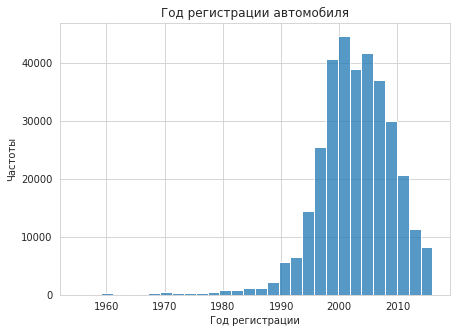

In [30]:
# строим гистограмму для дискретного количественного признака 'registration_year'
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
sns.histplot(data=auto_data, x='registration_year', bins=30)
plt.title('Год регистрации автомобиля')
plt.xlabel('Год регистрации')
plt.ylabel('Частоты')
plt.show()

**Вывод:** Мы отобрали строки, оставив только те, в которых нет явной ошибки в дате регистрации машины. Мы убрали машины с нереалистичными датами и такие, у которых дата регистрации задана более поздней датой по сравнению с датой выгрузки анкеты или регистрации на сайте (очевидно дата регистрации задана ошибочно). Мы также убрали незначильное число очень старых машин, которые можно считать выбросами.

In [31]:
# выводим распределение значений для дискретного количественного признака 'registration_month'
auto_data['registration_month'].value_counts()

registration_month
0     33512
3     33180
6     29610
4     27641
5     27413
7     25685
10    24647
12    22928
11    22871
9     22579
1     22420
8     21272
2     20537
Name: count, dtype: int64

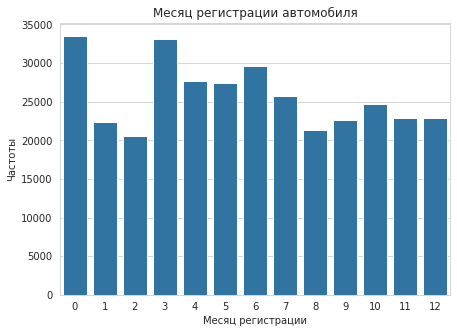

In [32]:
# строим график для дискретного количественного признака 'registration_month'
plt.figure(figsize=(7, 5))
sns.set_style("whitegrid")
sns.countplot(data=auto_data, x='registration_month')
plt.title('Месяц регистрации автомобиля')
plt.xlabel('Месяц регистрации')
plt.ylabel('Частоты')
plt.show()

**Вывод:** Мы видим, что у нас есть значение 0 по признаку месяца, которое явно не соответствует ни одному из месяцев. Вероятно, это либо ошибка, либо, что вероятнее, 0 указан для анкет, в которых месяц не задан. Мы решили оставить 0, посчитав,  что таким образом у нас будут закодированы те случаи, когда месяц не задан.

In [33]:
# выводим распределение значений для дискретного количественного признака 'number_of_pictures'
auto_data['number_of_pictures'].value_counts()

number_of_pictures
0    334295
Name: count, dtype: int64

По всем строкам значение признака равно 0. Можно сделать вывод, что данный признак никак не влияет на целевой признак и его можно удалить из датафрейма.

In [34]:
# создаем функцию для построения графиков для количественных признаков
def quant_feature(dataframe, feature, name, bins):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(14,5))
    fig.suptitle(name, fontsize=15)
    
    # построим диаграмму размаха
    sns.set_style("whitegrid")
    sns.boxplot(ax=axes[0], data = dataframe, y = feature)
    axes[0].set_title(f'Диаграмма размаха для признака: {feature}')
    axes[0].set_ylabel(f'{feature}')
    
    # строим гистрограмму
    sns.histplot(ax=axes[1], data=dataframe[feature], bins=bins)
    axes[1].set_title(f'Распределение значений признака: {feature}')
    axes[1].set_xlabel(f'{feature}')
    axes[1].set_ylabel('Частоты')
    plt.show()

In [35]:
# выводим описательную статистику для целевого признака 'price'
auto_data['price'].describe()

count    334295.000000
mean       4504.392423
std        4556.742537
min           0.000000
25%        1100.000000
50%        2800.000000
75%        6500.000000
max       20000.000000
Name: price, dtype: float64

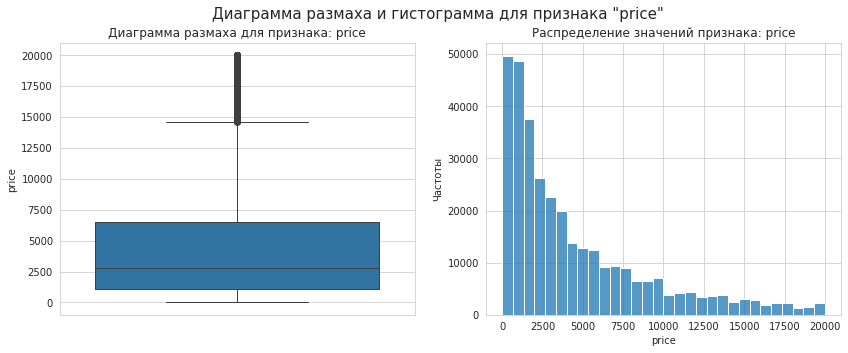

In [36]:
# строим графики для количественного целевого признака 'price'
quant_feature(auto_data, 'price', 'Диаграмма размаха и гистограмма для признака "price"', 30)

Цена с нулевым значением вероятно ошибочная или попопросту не задана. Мы считаем, что такие случае могут ухудшить качество прогнозной модели, поэтому следует их убрать из датафрейма для построения прогнозной модели.

In [37]:
# смотрим насколько много значений с нулевой ценой в датафрейме
print('Число строк с price = 0:', auto_data.query('price == 0').shape[0])
auto_data.query('price == 0').head()

Число строк с price = 0: 9686


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
40,2016-03-26 22:06:17,0,small,1990,manual,0,corsa,150000,1,petrol,opel,no information,2016-03-26 00:00:00,0,56412,2016-03-27 17:43:34
115,2016-03-20 18:53:27,0,small,1999,manual,0,golf,5000,0,petrol,volkswagen,no information,2016-03-20 00:00:00,0,37520,2016-04-07 02:45:22
152,2016-03-11 18:55:53,0,bus,2004,manual,101,meriva,150000,10,lpg,opel,yes,2016-03-11 00:00:00,0,27432,2016-03-12 23:47:10
154,2016-03-22 16:37:59,0,sedan,2006,manual,0,other,5000,0,petrol,fiat,no information,2016-03-22 00:00:00,0,44867,2016-04-06 06:17:56


In [38]:
# удаляем машины с нулевой ценой из выборки для построения моделей, чтобы улучшить качество прогнозной модели
auto_data = auto_data.query('price != 0')

In [39]:
# кроме того удалим ещё часть низких значений, которых сравнительно немного
print('Число строк с 0 < price < 10:', auto_data.query('0 < price < 10').shape[0])
auto_data.query('0 < price < 10').head()

Число строк с 0 < price < 10: 1137


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
59,2016-03-29 15:48:15,1,suv,1994,manual,286,unknown,150000,11,petrol,sonstige_autos,no information,2016-03-29 00:00:00,0,53721,2016-04-06 01:44:38
89,2016-03-28 09:37:01,1,sedan,1995,manual,113,e_klasse,150000,4,gasoline,mercedes_benz,no,2016-03-28 00:00:00,0,40589,2016-04-06 12:15:54
268,2016-03-12 07:26:49,1,sedan,1990,manual,90,80,70000,6,petrol,audi,no,2016-03-11 00:00:00,0,55122,2016-03-26 23:15:49
408,2016-03-29 18:51:58,1,sedan,2000,manual,75,golf,90000,3,petrol,volkswagen,no information,2016-03-29 00:00:00,0,78588,2016-04-06 04:45:50
901,2016-03-06 00:25:25,1,sedan,1990,manual,0,other,150000,0,petrol,porsche,no information,2016-03-05 00:00:00,0,65843,2016-04-06 20:19:08


In [40]:
# удалим машины с чрезвычайно низкой ценой
auto_data = auto_data.query('price >= 10')

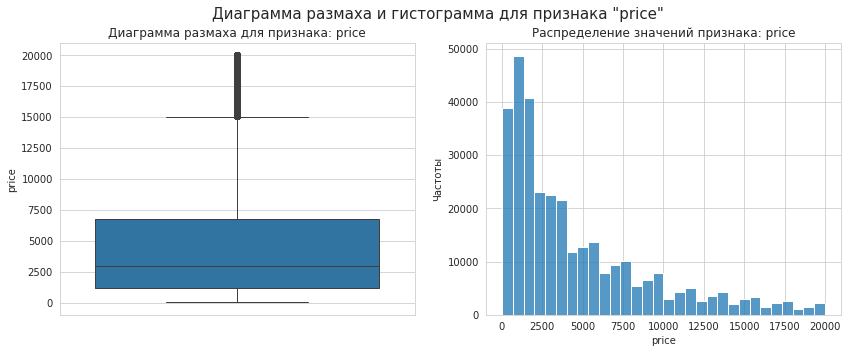

In [41]:
# повторно строим графики для количественного целевого признака 'price'
quant_feature(auto_data, 'price', 'Диаграмма размаха и гистограмма для признака "price"', 30)

In [42]:
# выводим описательную статистику для количественного признака 'power'
auto_data['power'].describe()

count    323472.000000
mean        112.481522
std         183.527760
min           0.000000
25%          71.000000
50%         105.000000
75%         143.000000
max       20000.000000
Name: power, dtype: float64

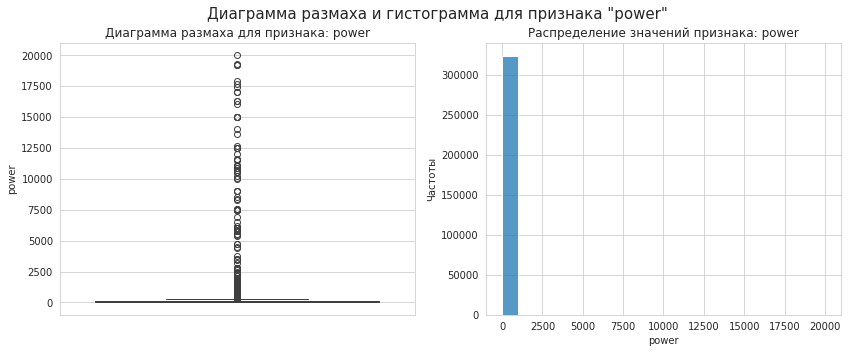

In [43]:
# строим графики для количественного целевого признака 'power'
quant_feature(auto_data, 'power', 'Диаграмма размаха и гистограмма для признака "power"', 20)

In [44]:
# график показывает наличие аномально высоких значений, смотрим, насколько их много в выборке
print('Число строк с power > 500:', auto_data.query('power > 500').shape[0])
auto_data.query('power > 500').head()

Число строк с power > 500: 379


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
1816,2016-03-22 20:52:00,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,2016-03-22 00:00:00,0,22043,2016-03-22 21:43:26
4060,2016-04-03 20:31:00,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,2016-04-03 00:00:00,0,60326,2016-04-07 14:56:46
5328,2016-03-29 19:44:48,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,no information,2016-03-29 00:00:00,0,33154,2016-04-06 05:44:36
6296,2016-03-31 23:50:47,599,small,2002,manual,603,matiz,5000,11,petrol,chevrolet,yes,2016-03-31 00:00:00,0,44379,2016-04-01 03:41:52
6504,2016-03-14 15:54:34,3000,small,2009,manual,771,punto,125000,0,petrol,fiat,no information,2016-03-14 00:00:00,0,40721,2016-03-14 15:54:34


В большинстве из случаев мощность свыше 500 л.с. явно задана ошибочно, поэтому мы решили удалить эти строки из датафрейма для построения прогнозной модели.

In [45]:
# удаляем из датафрейма автомобили мощнее 500 л.с.
auto_data = auto_data.query('power <= 500')

In [46]:
# теперь посмотрим, насколько много в выборке машин с нулевой мощностью
print('Число строк с power = 0:', auto_data.query('power == 0').shape[0])
auto_data.query('power == 0').head()

Число строк с power = 0: 31079


,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired,date_created,number_of_pictures,postal_code,last_seen
0,2016-03-24 11:52:17,480,sedan,1993,manual,0,golf,150000,0,petrol,volkswagen,no information,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
32,2016-03-15 20:59:01,245,sedan,1994,manual,0,golf,150000,2,petrol,volkswagen,no,2016-03-15 00:00:00,0,44145,2016-03-17 18:17:43
37,2016-03-28 17:50:15,1500,bus,2016,manual,0,kangoo,150000,1,gasoline,renault,no,2016-03-28 00:00:00,0,46483,2016-03-30 09:18:02
54,2016-03-17 07:56:40,4700,wagon,2005,manual,0,signum,150000,0,gasoline,opel,no,2016-03-17 00:00:00,0,88433,2016-04-04 04:17:32
55,2016-03-26 10:39:35,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,2016-03-26 00:00:00,0,56759,2016-04-01 23:17:27


Мощность равная 0 л.с. явно задана ошибочно, либо это свидетельсвто того, что мощность не задана. Т.к. строк с нулевой мощностью сравнительно много, удалять их не стоит. Принято решение заполнить нулевые значения медианными значениями мощности безь учёта нулевых значений.

In [47]:
# заполним нулевые значения мощности медианными значениями (без учёта нулевых) для соответствующих моделей
for mod in auto_data['model'].unique():
    try:
        auto_data.loc[
                      (auto_data['power'] == 0) & (auto_data['model'] == mod), 'power'
                     ] = round(auto_data.loc[(auto_data['model'] == mod) & (auto_data['power'] !=0),
                            'power'].median())
    except:
        auto_data.loc[(auto_data['power'] == 0) & (auto_data['model'] == mod), 'power'] = 0

In [48]:
# смотрим, остались ли нулевые значения
print('Число строк с power=0:', auto_data.query('power == 0').shape[0])

Число строк с power=0: 1


In [49]:
# удаляем строку с нулевым значением мощности
auto_data = auto_data.query('power != 0')

In [50]:
# повторно выводим описательную статистику для количественного признака 'power'
auto_data['power'].describe()

count    323092.000000
mean        119.515451
std          52.547982
min           1.000000
25%          75.000000
50%         110.000000
75%         147.000000
max         500.000000
Name: power, dtype: float64

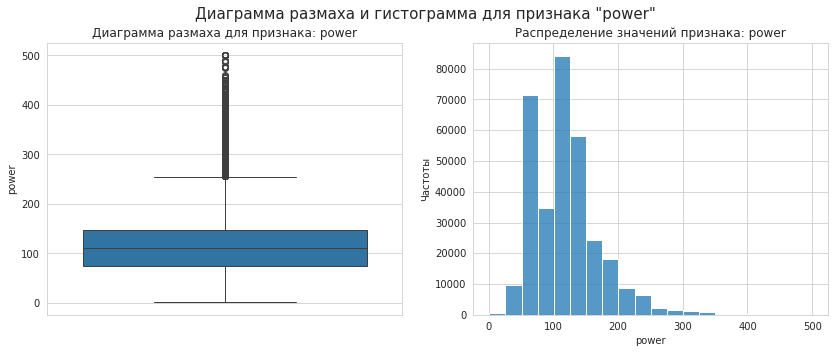

In [51]:
# строим графики для количественного целевого признака 'power'
quant_feature(auto_data, 'power', 'Диаграмма размаха и гистограмма для признака "power"', 20)

In [52]:
# выводим описательную статистику для количественного признака 'kilometer'
auto_data['kilometer'].describe()

count    323092.000000
mean     128187.188169
std       37427.412853
min        5000.000000
25%      125000.000000
50%      150000.000000
75%      150000.000000
max      150000.000000
Name: kilometer, dtype: float64

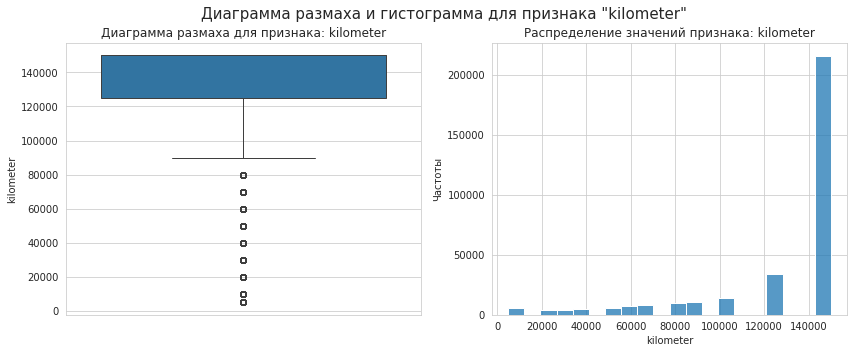

In [53]:
# строим графики для количественного целевого признака 'kilometer'
quant_feature(auto_data, 'kilometer', 'Диаграмма размаха и гистограмма для признака "kilometer"', 20)

In [54]:
# удаляем признаки, которые мы не будем использовать в моделировании
auto_data = auto_data.drop(['number_of_pictures', 'postal_code', 'date_crawled',
                            'date_created', 'last_seen'], axis =1)

In [55]:
# пазмерность и первые строки датафрейма
print('Размерность датафрейма auto_data после предобработки и исследовательского анализа:',
      auto_data.shape)
auto_data.head()

Размерность датафрейма auto_data после предобработки и исследовательского анализа: (323092, 11)


,price,vehicle_type,registration_year,gearbox,power,model,kilometer,registration_month,fuel_type,brand,repaired
0,480,sedan,1993,manual,101,golf,150000,0,petrol,volkswagen,no information
1,18300,coupe,2011,manual,190,a4,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no information
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


### Корреляционный анализ данных 

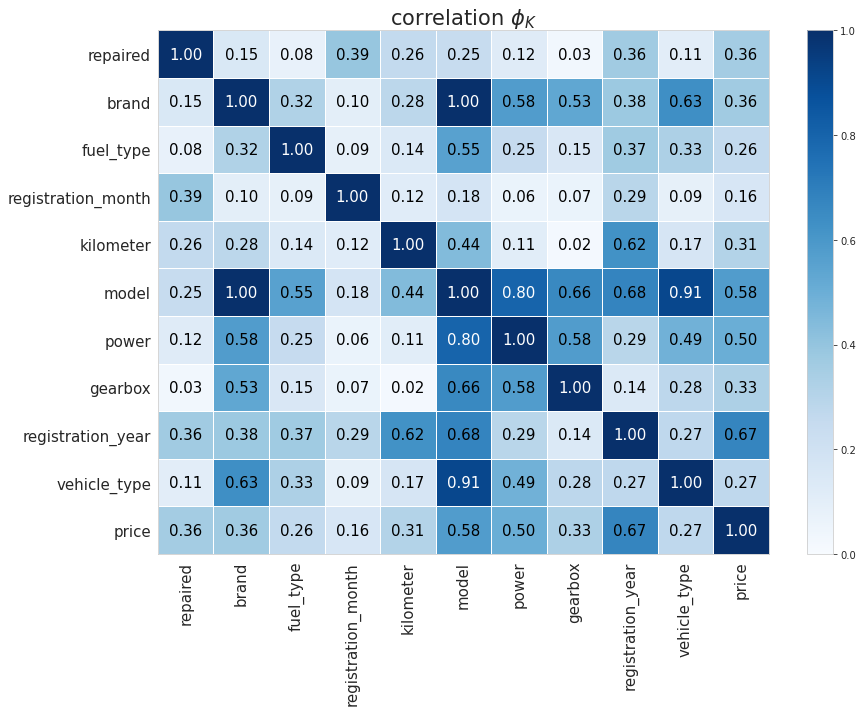

In [56]:
# задаем непрерывные величины и считаем корреляционную матрицу между всеми признаками датафрейма auto_data
interval_cols = ['price', 'power', 'kilometer']
phik_overview = phik_matrix(auto_data, interval_cols = interval_cols)

# визуализируем корреляции между всеми признаками датафрейма auto_data
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns,\
                        y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Blues',\
                        title='correlation $\phi_K$', fontsize_factor=1.5, figsize=(13, 10))

Мы обнаружили по матрице наличие мультиколлениарности между признаками 'model' и 'brand', 'model' и 'vehicle_type'. Исключаем признаки 'brand', 'vehicle_type' и заново выводим корреляционную матрицу. Затем также исключим эти признаки из финального датафйрема для подбора прогнозной модели, предсказывающей цену автомобиля, чтобы устранить негативное влияние мультиколлениарности на прогностическую способность модели.

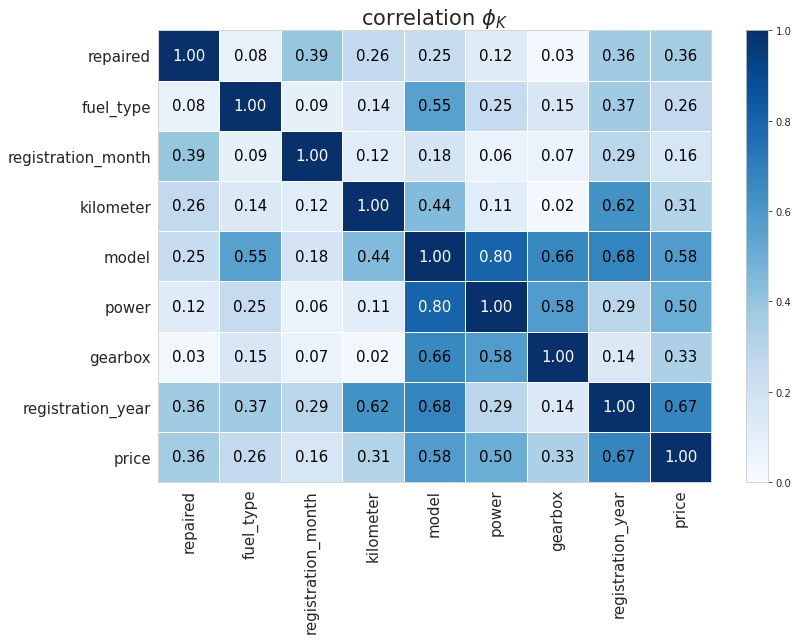

In [57]:
# повторно считаем корреляционную матрицу между признаками датафрейма auto_data 
phik_overview = phik_matrix(auto_data.drop(['brand', 'vehicle_type'], axis=1),
                            interval_cols = interval_cols)

# визуализируем корреляции между всеми признаками датафрейма auto_data
plot_correlation_matrix(phik_overview.values, x_labels=phik_overview.columns,\
                        y_labels=phik_overview.index, vmin=0, vmax=1, color_map='Blues',\
                        title='correlation $\phi_K$', fontsize_factor=1.5, figsize=(12, 9))

In [58]:
# исключаем признаки 'brand', 'vehicle_type' из датафрейма
auto_data = auto_data.drop(['brand', 'vehicle_type'], axis=1)

In [59]:
# выведем общую информацию по датафрейму, сформированнуому для моделирования
auto_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 323092 entries, 0 to 354368
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype 
---  ------              --------------   ----- 
 0   price               323092 non-null  int64 
 1   registration_year   323092 non-null  int64 
 2   gearbox             323092 non-null  object
 3   power               323092 non-null  int64 
 4   model               323092 non-null  object
 5   kilometer           323092 non-null  int64 
 6   registration_month  323092 non-null  int64 
 7   fuel_type           323092 non-null  object
 8   repaired            323092 non-null  object
dtypes: int64(5), object(4)
memory usage: 24.6+ MB


**Выводы:**

Мы выгрузили данные и сохранили в датафрейм. Прежде всего мы убедились, что тип данных для всех признаков задан правильно, и что в данных есть пропуски. Затем мы привели названия всех столбцов к единому змеиному регистру. После этого мы проверили данные на наличие явных и скрытых дубликатов, удалили дубликаты. На следующем этапе мы заполнили пустые значения в датафрейме. Пропуски для признака 'model' мы заполнили наиболее часто встречающимися значениями 'model', но только среди машин, у которых значение 'brand' (у этого признака нет пропусков) совпадает с машиной, у которой значение 'model' пропущено. В том случае если такого модального значения 'model' для бренда определить невозможно (например, если все значения 'model' по бренду не заполнены), мы заполнили пропуски по признаку 'model' значениями 'unknown'. Пропуски для признаков 'vehicle_type', 'fuel_type' и 'gearbox' мы заполнили наиболее часто встречающимися значениями признаков среди машин у которых значение 'model' (у этого признака на данном этапе нет пропусков) совпадает с машиной, у которой значение 'vehicle_type', 'fuel_type' и 'gearbox' пропущено. В том случае, если такого наиболее часто встречающегося значения 'vehicle_type', 'fuel_type' и 'gearbox' для модели машины определить невозможно, мы заполнили пропуски значениями 'unknown'. Пропуски по признаку 'repaired' мы заполнили значениями 'no information'

На следующем этапе мы обработали аномалии и выбросы в количественных признаках. Мы ограничили количественный дискретный признак 'registration_year' значениями с 1955-го по 2017 год. Часть значений по признаку были заданы нереалистично, а по части старых машин сравнительно немного значений. Мы также удалили из датафрейма машины, у которых дата регистрации задана более поздней датой по сравнению с датой выгрузки анкеты или регистрации на сайте - очевидно, дата регистрации для таких машин задана ошибочно. По признаку 'registration_month' мы обнаружили значение 0, которое не может соответствовать ниодному месяцу, но мы оставили это значение, т.к. оно отличается от остальных и таким образом под значением 0 у нас учитены пропущенные значения. Для дискретного признака 'number_of_pictures' все значения нулевые (вероятно, они не заданы), поэтому этот признак бесполезен для моделирования.

Для количественных непрерывных признаков 'price', 'power', 'kilometer' мы построили диаграммы размаха и гистограммы, показывающие распределение признака. Мы удалили из датафрейма все строки с нулевыми значениями признака 'price', т.к. это по всей видимости ошибка, либо свидетельство незаполненности значений признака, а также удалили строки с крайне низкими значеними признака 'price' (ниже 10), т.к. они также выглядят нереалистично. По признаку 'power' мы удалили строки со значениями выше 500, т.к. они являются выбросами или аномально высокими (значения вплоть до 20000), их было сравнительно немного. Мы обнаружили, что нулевых значений по признаку 'power' очень много, по всей вероятности данные в этом случае просто не заполнены. Мы заменили нулевые значения по признаку 'power' на медианные значения признака среди машин с совпадающим значенияем признака 'model', исключив при этом из расчёта медианы нулевые значения признака 'power'. В случае ненахлождения медианного значения мощности для модели (например если для всех машин модели заданы нулевые значения) мы оставили нулевое значение и затем удалили оставшуюся строку с нулевым значением мощности из выборки. Для признака 'kilometer' аномальных значений не обнаружено.

Мы убрали из выборки признаки 'number_of_pictures', 'postal_code', 'date_crawled', 'date_created', 'last_seen' как малоинформативные для моделирования и не оказывающие влияния на целевой признак 'price'. Затем для всех оставшихся признаков мы посчитали и вывели корреляционную матрицу со значениями коэффициента корреляции Фи, который можно исппользовать как для количественных так и категориальных признаков. Матрица показала наличие полной мультиколлениарности между признаками 'model' 'brand' (коэффициент равен 1) и сильной мультиколлениарности между признаками 'model' и 'vehicle_type' (коэффициент равен 0.92). Поэтому мы решили убрать из выборки для моделирования также и признаки 'brand' и 'vehicle_type', т.к. они в меньшей степени связаны с целевым признаком 'price' по сравнению с признаком 'model': коэффициенты корреляции 0.36 и 0.27 против 0.57. Целевой признак 'price' имеет заметную тесноту связи с признаками 'registration_year' (0.69), 'model' (0.57), 'power'(0.50).

## Обучение моделей

In [60]:
# фиксируем категориальные признаки для кодирования в модели
auto_data[['gearbox', 'model', 'fuel_type', 'repaired']] = auto_data[
    ['gearbox', 'model', 'fuel_type', 'repaired']].astype('category')

#разделяем выборку на тренировочные и тестовые данные
X_train, X_test, y_train, y_test = train_test_split(auto_data.drop('price', axis=1),
                                                    auto_data['price'],
                                                   random_state=RANDOM_STATE,
                                                    test_size=TEST_SIZE)

In [61]:
# в качестве первой модели инициализируем LGBMRegressor
model = LGBMRegressor(objective="regression")
# задаём словарь гиперпараметров
param_gs = {
        'learning_rate': [0.3],
        'max_depth': [15, 20],
        'n_estimators': [20, 80]
            }

gs_lgb = GridSearchCV(model, param_grid=param_gs, cv=5, scoring='neg_root_mean_squared_error',
                        n_jobs=-1, verbose=3)

GridSearchCV(cv=5, estimator=LGBMRegressor(objective='regression'), n_jobs=-1,
             param_grid={'learning_rate': [0.3], 'max_depth': [15, 20],
                         'n_estimators': [20, 80]},
             scoring='neg_root_mean_squared_error')

In [62]:
# выводим лучшую обученную модель и её гиперпараметры
print('Лучшая обученная модель и её параметры:\n\n', gs_lgb.best_estimator_,
      '\n\n', gs_lgb.best_params_, '\n\n')
# выводим общие результаты поиска гиперпараметров лучшей модели
print('\033[1mОбщие результаты поиска гиперпараметров лучшей модели:\033[0m')
display(pd.DataFrame(gs_lgb.cv_results_))

Лучшая обученная модель и её параметры:

 LGBMRegressor(learning_rate=0.3, max_depth=15, n_estimators=80,
              objective='regression') 

 {'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 80} 


Общие результаты поиска гиперпараметров лучшей модели:


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,12.655677,2.056543,0.154498,0.041465,0.3,15,20,"{'learning_rate': 0.3, 'max_depth': 15, 'n_est...",-1731.185604,-1759.673115,-1760.412257,-1797.007350,-1735.624807,-1756.780627,23.419729,3
1,8.594972,9.852990,0.322301,0.033993,0.3,15,80,"{'learning_rate': 0.3, 'max_depth': 15, 'n_est...",-1664.174657,-1692.604052,-1691.648302,-1726.313823,-1668.689183,-1688.686003,22.093701,1
2,1.815510,0.852247,0.104418,0.002453,0.3,20,20,"{'learning_rate': 0.3, 'max_depth': 20, 'n_est...",-1733.847576,-1759.673115,-1760.412257,-1797.007350,-1735.624807,-1757.313021,22.855287,4
3,3.097031,0.252202,0.303445,0.001514,0.3,20,80,"{'learning_rate': 0.3, 'max_depth': 20, 'n_est...",-1669.616308,-1691.954093,-1691.648302,-1727.269364,-1668.689183,-1689.835450,21.284038,2


In [63]:
# задаём категориальные признаки для кодирования и количественные признаки для масштабирования
targ_columns = ['model', 'fuel_type']
ohe_columns = ['gearbox', 'repaired']
num_columns = ['kilometer', 'power', 'registration_year', 'registration_month']

In [64]:
# создаем пайплайн для кодирования признаков с помощью OneHotRecorder
ohe_pipe = Pipeline(
    [
        (
            'simple_imputer_before_ohe',
            SimpleImputer(missing_values=np.nan, strategy='most_frequent')
        ),
        (
            'encoder', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=True) 
        ) 
    ]
)

# создаем пайплайн для масштабирования признаков с помощью StandardScaler
num_pipe = Pipeline(
    [
        (
            'simple_imputer_before_num',
            SimpleImputer(missing_values=np.nan, strategy='median')
        ),
        (
            'scaler', StandardScaler() 
        ) 
    ]
)

In [65]:
# создаем пайплайн для обработки данных
data_preprocessor = ColumnTransformer(
    [
        ('targ', TargetEncoder(target_type='continuous', smooth=7,
                               random_state=RANDOM_STATE), targ_columns),
        ('num', num_pipe, num_columns),
        ('ohe', ohe_pipe, ohe_columns)
    ], 
    remainder='passthrough'
)

In [66]:
# создаем финальный пайплайн
pipe_final = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', KNeighborsRegressor())
    ]
)

In [67]:
# задаём гиперпараметры для моделей
param_rs = [
     # для модели KNeighborsRegressor()
    {
        'models': [KNeighborsRegressor(n_jobs=-1)],
        'models__n_neighbors': [7, 10, 12, 15],
        'models__p': [1, 2],
        'preprocessor__num': [StandardScaler()]
    },
         # для модели DecisionTreeRegressor()
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': [20, 25, 30],
        'models__min_samples_leaf': [7, 10, 15, 18]
    }  
             ]


In [68]:
# инициализируем класс для автоматизированного поиска лучших гиперпараметров на данных кросс-валидационной выборки 
# запускаем поиск гиперпараметров для небустинг модели c помощью RandomizedSearchCV
rs_non_lgb = GridSearchCV(pipe_final, param_grid=param_rs, cv=5, scoring='neg_root_mean_squared_error',
                        n_jobs=-1, verbose=3)
rs_non_lgb.fit(X_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END models=KNeighborsRegressor(n_jobs=-1), models__n_neighbors=7, models__p=1, preprocessor__num=StandardScaler();, score=-2473.182 total time=   3.6s
[CV 2/5] END models=KNeighborsRegressor(n_jobs=-1), models__n_neighbors=7, models__p=1, preprocessor__num=StandardScaler();, score=-2560.710 total time=   3.7s
[CV 3/5] END models=KNeighborsRegressor(n_jobs=-1), models__n_neighbors=7, models__p=1, preprocessor__num=StandardScaler();, score=-2474.618 total time=   3.2s
[CV 4/5] END models=KNeighborsRegressor(n_jobs=-1), models__n_neighbors=7, models__p=1, preprocessor__num=StandardScaler();, score=-2647.874 total time=   3.0s
[CV 5/5] END models=KNeighborsRegressor(n_jobs=-1), models__n_neighbors=7, models__p=1, preprocessor__num=StandardScaler();, score=-2640.414 total time=   3.0s
[CV 1/5] END models=KNeighborsRegressor(n_jobs=-1), models__n_neighbors=7, models__p=2, preprocessor__num=StandardScaler();, score=-2658.4

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(remainder='passthrough',
                                                          transformers=[('targ',
                                                                         TargetEncoder(random_state=12345,
                                                                                       smooth=7,
                                                                                       target_type='continuous'),
                                                                         ['model',
                                                                          'fuel_type']),
                                                                        ('num',
                                                                         Pipeline(steps=[('simple_imputer_before_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['kilometer',
                                                                          'power...
                                       ('models', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid=[{'models': [KNeighborsRegressor(n_jobs=-1)],
                          'models__n_neighbors': [7, 10, 12, 15],
                          'models__p': [1, 2],
                          'preprocessor__num': [StandardScaler()]},
                         {'models': [DecisionTreeRegressor(random_state=12345)],
                          'models__max_depth': [20, 25, 30],
                          'models__min_samples_leaf': [7, 10, 15, 18]}],
             scoring='neg_root_mean_squared_error', verbose=3)

In [69]:
# выводим лучшую обученную модель и её гиперпараметры
print('Лучшая модель и её параметры:\n\n', rs_non_lgb.best_estimator_, '\n\n')
# выводим общие результаты поиска гиперпараметров лучшей модели
print('\033[1mОбщие результаты поиска гиперпараметров лучшей модели:\033[0m')
display(pd.DataFrame(rs_non_lgb.cv_results_))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targ',
                                                  TargetEncoder(random_state=12345,
                                                                smooth=7,
                                                                target_type='continuous'),
                                                  ['model', 'fuel_type']),
                                                 ('num',
                                                  Pipeline(steps=[('simple_imputer_before_num',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['kilometer', 'power',


,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_models,param_models__n_neighbors,param_models__p,param_preprocessor__num,param_models__max_depth,param_models__min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.670485,0.009723,2.638215,0.298860,KNeighborsRegressor(n_jobs=-1),7.0,1.0,StandardScaler(),NaN,NaN,"{'models': KNeighborsRegressor(n_jobs=-1), 'mo...",-2473.181818,-2560.710258,-2474.617843,-2647.873746,-2640.413670,-2559.359467,76.176264,15
1,0.661088,0.018852,1.789123,0.238365,KNeighborsRegressor(n_jobs=-1),7.0,2.0,StandardScaler(),NaN,NaN,"{'models': KNeighborsRegressor(n_jobs=-1), 'mo...",-2658.490396,-2734.958476,-2649.124460,-2769.146745,-2830.808456,-2728.505707,68.355996,18
2,0.671481,0.024488,2.813875,0.322198,KNeighborsRegressor(n_jobs=-1),10.0,1.0,StandardScaler(),NaN,NaN,"{'models': KNeighborsRegressor(n_jobs=-1), 'mo...",-2466.554960,-2546.162775,-2459.904027,-2648.565125,-2615.617938,-2547.360965,76.264092,13
3,0.607785,0.023548,1.638153,0.194532,KNeighborsRegressor(n_jobs=-1),10.0,2.0,StandardScaler(),NaN,NaN,"{'models': KNeighborsRegressor(n_jobs=-1), 'mo...",-2657.891659,-2728.799148,-2699.899356,-2760.564025,-2793.057989,-2728.042435,46.900774,17
4,0.601401,0.008956,2.490140,0.238684,KNeighborsRegressor(n_jobs=-1),12.0,1.0,StandardScaler(),NaN,NaN,"{'models': KNeighborsRegressor(n_jobs=-1), 'mo...",-2471.560260,-2544.530107,-2461.197413,-2647.381208,-2617.554032,-2548.444604,74.970878,14
5,0.590320,0.010760,1.723953,0.222339,KNeighborsRegressor(n_jobs=-1),12.0,2.0,StandardScaler(),NaN,NaN,"{'models': KNeighborsRegressor(n_jobs=-1), 'mo...",-2668.333460,-2733.423769,-2695.566746,-2754.895809,-2790.732980,-2728.590553,43.124232,19
6,0.589252,0.007786,2.732321,0.330980,KNeighborsRegressor(n_jobs=-1),15.0,1.0,StandardScaler(),NaN,NaN,"{'models': KNeighborsRegressor(n_jobs=-1), 'mo...",-2493.714626,-2558.571702,-2471.734664,-2653.467946,-2631.128366,-2561.723461,72.065540,16
7,0.592611,0.018297,1.822024,0.206047,KNeighborsRegressor(n_jobs=-1),15.0,2.0,StandardScaler(),NaN,NaN,"{'models': KNeighborsRegressor(n_jobs=-1), 'mo...",-2688.958927,-2741.890985,-2677.381823,-2762.611721,-2807.001019,-2735.568895,47.816433,20
8,0.932543,0.014724,0.067046,0.003862,DecisionTreeRegressor(random_state=12345),NaN,NaN,NaN,20.0,7.0,{'models': DecisionTreeRegressor(random_state=...,-1888.255182,-1921.625657,-1903.476838,-1937.693651,-1894.946220,-1909.199510,18.115713,10
9,0.905502,0.004900,0.064560,0.004991,DecisionTreeRegressor(random_state=12345),NaN,NaN,NaN,20.0,10.0,{'models': DecisionTreeRegressor(random_state=...,-1886.374441,-1895.661368,-1883.806506,-1928.489089,-1874.248256,-1893.715932,18.676412,9


**Выводы:**

На данном этапе мы провели обучение нескольких моделей, для которых использовали подбор оптимальных гиперпараметров. Мы выбрали для сравнения одну модель градиентного бустинга LGBMRegressor(), а также в качестве альтернативы выбрали две нелинейные модели регрессии DecisionTreeRegressor() и KNeighborsRegressor(). Предварительно мы задали категориальные признаки  сделали 'gearbox', 'model', 'fuel_type', 'repaired' и сделали разбивку выборки на тренировочную и тестовую. Мы инициализировали модель LGBMRegressor(), задали для неё словарь гиперпараметров для параметров 'learning_rate','max_depth' и 'n_estimators'. Затем мы инициализировали класс для автоматизированного поиска лучших гиперпараметров на данных кросс-валидационной выборки и запустили поиск гиперпараметров c помощью GridSearchCV (с учетом гиперпараметров рассмотрено 8 вариантов модели). Лучшая модель LGBMRegressor() получена при значениях гиперпарметров 'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 80.

Для построения прогнозов с помощью DecisionTreeRegressor() и KNeighborsRegressor() мы использовали пайплайн, в который поместили обработку значений категориальных и количественных признаков с помощью кодировщиков OneHotEncoder и TargetEncoder, а также скалера для масштабирования StandardScaler. Мы обработали данные в пайплайне ColumnTransformer, затем создали финальный пайплайн для прогноза целевого признака и задали словари гиперпараметров: со значениями параметра 'n_neighbors' и 'p', а также скалером StandardScaler для масштабирования для модели KNeighborsRegressor(), значениями параметров 'min_samples_leaf' и 'max_depth' для DecisionTreeRegressor(). Мы запустили поиск гиперпараметров для лучшей модели на кросс-валидационной выборки c помощью GridSearchCV. В результате мы получили, что лушей является модель DecisionTreeRegressor() с параметрами max_depth=25, min_samples_leaf=18. Обучение небустинговой модели проходило заметно быстрее по сравнению с LightGBM.

## Анализ моделей

In [70]:
# определяем время обучения лучшей модели типа LGBMRegressor() и качество предсказания для неё
lgb_results = pd.DataFrame(gs_lgb.cv_results_).sort_values(by='rank_test_score')
print('Время обучения модели LGBMRegressor():',
      round(lgb_results.iloc[0, 0], 2))
print('Скорость предсказания с помощью модели LGBMRegressor():',
      round(lgb_results.iloc[0, 2], 2))
print('Качество предсказания модели LGBMRegressor() — ошибка RMSE:',
      abs(round(lgb_results.iloc[0, 13], 2)))

Время обучения модели LGBMRegressor(): 8.59
Скорость предсказания с помощью модели LGBMRegressor(): 0.32
Качество предсказания модели LGBMRegressor() — ошибка RMSE: 1688.69


In [71]:
# определяем время обучения лучшей модели типа, отличного от бустинга, и качество предсказания для неё
non_lgb_results = pd.DataFrame(rs_non_lgb.cv_results_).sort_values(by='rank_test_score')
print(f'Время обучения модели {non_lgb_results.iloc[0, 4]}:',
      round(non_lgb_results.iloc[0, 0], 2))
print(f'Скорость предсказания с помощью модели {non_lgb_results.iloc[0, 4]}:',
      round(non_lgb_results.iloc[0, 2], 2))
print(f'Качество предсказания модели {non_lgb_results.iloc[0, 4]} — ошибка RMSE:',
      abs(round(non_lgb_results.iloc[0, 15], 2)))

Время обучения модели DecisionTreeRegressor(random_state=12345): 0.89
Скорость предсказания с помощью модели DecisionTreeRegressor(random_state=12345): 0.07
Качество предсказания модели DecisionTreeRegressor(random_state=12345) — ошибка RMSE: 1863.84


In [72]:
# отобразим результаты двух моделей в табличной форме
pd.DataFrame({'model': ['LGBMRegressor', 'DecisionTreeRegressor'], 
              'fit_time': [round(lgb_results.iloc[0, 0], 2), round(non_lgb_results.iloc[0, 0], 2)],
             'predict_time': [round(lgb_results.iloc[0, 2], 2), round(non_lgb_results.iloc[0, 2], 2)],
             'RMSE': [abs(round(lgb_results.iloc[0, 13], 2)), abs(round(non_lgb_results.iloc[0, 15], 2))]})

,model,fit_time,predict_time,RMSE
0,LGBMRegressor,8.59,0.32,1688.69
1,DecisionTreeRegressor,0.89,0.07,1863.84


In [79]:
# считаем для лучшей модели метрику RMSE на тестовой выборке
y_pred_non_lgb = rs_non_lgb.predict(X_test)
rmse_best_model = root_mean_squared_error(y_test, y_pred_non_lgb)
print('Качество лучшей модели на тестовой выборке — ошибка RMSE:', round(rmse_best_model, 2))

Качество лучшей модели на тестовой выборке — ошибка RMSE: 1848.54


In [80]:
# проверим лучшую модель на адекватность, сравнив качество её предсказаний с качеством модели DummyRegressor(strategy="median")
dummy_model = DummyRegressor(strategy="median")
dummy_model.fit(X_train, y_train)
y_pred_dummy = dummy_model.predict(X_test)
rmse_test_dummy = root_mean_squared_error(y_test, y_pred_dummy)
print('Значение метрики RMSE для модели DummyRegressor на тестовой выборке:',
      round(rmse_test_dummy, 2))

Значение метрики RMSE для модели DummyRegressor на тестовой выборке: 4838.9


In [81]:
# посчитаем ошибки по модулю для каждого прогноза
errors = abs(y_test - y_pred_non_lgb)
# сохраним и выведем первые строки датафрейма с реальными, прогнозными значениями и ошибками
y_pred_test = pd.DataFrame({'real_price': y_test, 'predicted_price': np.around(y_pred_lgb,
                                                                               decimals=0),
                            'errors': round(errors)}).reset_index(drop='True')
y_pred_test.head()

,real_price,predicted_price,errors
0,3600,4372.0,61.0
1,3850,3527.0,1832.0
2,200,239.0,105.0
3,1780,2238.0,580.0
4,1750,1311.0,150.0


In [82]:
# сформируем произвольную выборку из датафрейма
pred_test_sample = y_pred_test.sample(n=1000, random_state= RANDOM_STATE).reset_index(drop='True')

<function matplotlib.pyplot.show(close=None, block=None)>

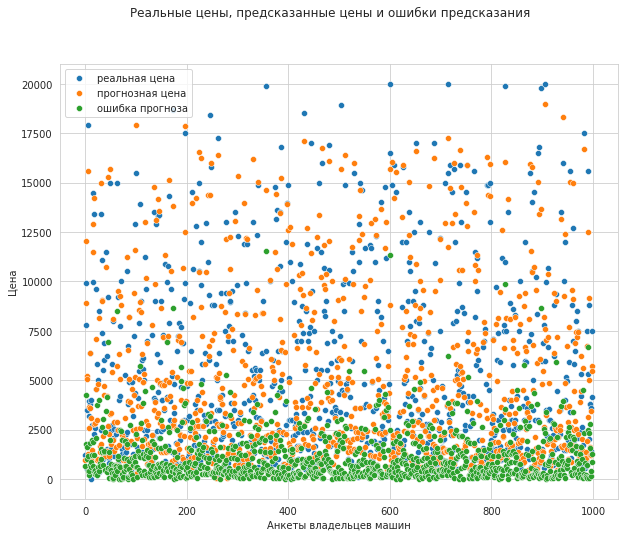

In [83]:
# на графике отобразим реальные цены, прногнозы и ошибки по выборке из 1000 машин
fig, ax = plt.subplots(figsize=(10,8))
fig.suptitle('Реальные цены, предсказанные цены и ошибки предсказания', fontsize=12)
a = sns.scatterplot(ax=ax, data=pred_test_sample, x = pred_test_sample.index, y= 'real_price')
b = sns.scatterplot(ax=ax, data=pred_test_sample, x = pred_test_sample.index, y= 'predicted_price')
c = sns.scatterplot(ax=ax, data=pred_test_sample, x = pred_test_sample.index, y= 'errors')
plt.ylabel('Цена')
plt.xlabel('Анкеты владельцев машин')
plt.legend(['реальная цена', 'прогнозная цена', 'ошибка прогноза'])
plt.show

**Выводы:**

Мы сранили лучшую обученную модель LGBMRegressor() и лучшую небустинговую модель DecisionTreeRegressor() по времени обучения, скорости предсказания и качеству полученных предсказаний с помощью метрики RMSE. Мы выявили, что модель LGBMRegressor() обучается медленнее модели DecisionTreeRegressor(): обучение проходит примерно в 9.5 раз медленнее. Также модель LGBMRegressor() мдленнее выдает предсказания. Скорость предсказания модели LGBMRegressor() в 4.5 раз медленнее скорости предсказания модели DecisionTreeRegressor(). При этом модель LGBMRegressor() заметно меньше ошибается. Среднее значение RMSE на кросс-валидационной выборке для модели LGBMRegressor() равно 1689, тогда как среднее значение RMSE на кросс-валидационной выборке для модели DecisionTreeRegressor() равно 1864. Очевидно, ни одна из моделей не выигрывает по всем показателям. Если для заказчика важнее скорость обучения и предсказания, но не так важна точность модели, то можно смело рекомендовать модель DecisionTreeRegressor(). А если все же важнее точность предсказания, то нужно рекомендовать LGBMRegressor(), при том что модель работает сравнительно быстро. В качестве лучшей модели для прогнозирования цены автомобиля мы выбираем модель DecisionTreeRegressor(), которая заметно превосходит модель LGBMRegressor() по скорости обучения и предсказания, и хотя и уступает по метрике ошибки RMSE, даёт сравнительно небольшую ошибку. На тестовой выборке для выбранной модели мы получили значение метрики RMSE = 1673. В заключении мы также проверили выбранную модель на адекватность, сравнив её с моделью DummyRegressor, которая по каждому прогнозу присваивает медианные значения целевого показателя. Для DummyRegressor мы получили на тестовой выборке значение RMSE = 4805, что гораздо выше чем для выбранной для прогнозирования модели. Это означает адекватность выбранной для прогнозирования модели.

## Общий вывод 

На этапе подготовки данных мы убедились в правильноти типа данных для каждого признака, привели все названия признаков к змеиному регистру, проверили выборку на наличие дубликатов (явных и неявных). Затем мы по возможности заполнили пустые значения для категориальных признаков, заменив пустые значения на наиболее частые значения, встречающиеся по выбранной категории. Количественные признаки, среди которых не обнаружено пропусков, мы проверили на наличие выбросов и аномальных значений. Му увдалили строки с аномальными значениями, а нулевые значения для части признаков заменили на медианные значения по выббранной категории. На заключительном этапе подготовки данных мы отобрали признаки для моделирования и убрали неинформативные признаки, либо признаки, которые могут помещать адекватной работе прогнозной модели. Так мы убрали из выборки признаки 'number_of_pictures', 'postal_code', 'date_crawled', 'date_created', 'last_seen' как малоинформативные для моделирования и не оказывающие влияния на целевой признак 'price'. Для всех оставшихся признаков мы посчитали и вывели корреляционную матрицу со значениями коэффициента корреляции Фи, который хорошо подходит не только для количественных, но и для категориальных признаков. Корреляционная матрица показала наличие полной мультиколлениарности между признаками 'model' 'brand' (коэффициент равен 1) и сильной мультиколлениарности между признаками 'model' и 'vehicle_type' (коэффициент равен 0.92). Мы решили убрать из выборки для моделирования также признаки 'brand' и 'vehicle_type', т.к. они в меньшей степени связаны с целевым признаком 'price' по сравнению с признаком 'model'. Целевой признак 'price' имеет заметную тесноту связи с признаками 'registration_year' (0.69), 'model' (0.57), 'power'(0.50).

Мы провели обучение нескольких моделей, для которых использовали подбор оптимальных гиперпараметров: 1) модель градиентного бустинга LGBMRegressor(); 2) нелинейную регрессионную модель DecisionTreeRegressor(); 3) нелинейную регрессионную модель KNeighborsRegressor(). Предварительно мы задали категориальные признаки  сделали 'gearbox', 'model', 'fuel_type', 'repaired' и сделали разбивку выборки на тренировочную и тестовую. Мы инициализировали модель LGBMRegressor(), задали для неё словарь гиперпараметров: 'learning_rate','max_depth' и 'n_estimators'. Затем мы запустили поиск гиперпараметров c помощью GridSearchCV на кросс-валидационной выборке. Лучшая модель LGBMRegressor() получена при значениях гиперпарметров 'learning_rate': 0.3, 'max_depth': 15, 'n_estimators': 80. Для построения прогнозов с помощью DecisionTreeRegressor() и KNeighborsRegressor() мы использовали пайплайн, в который поместили обработку значений категориальных и количественных признаков с помощью кодировщиков OneHotEncoder, TargetEncoder и скалера для масштабирования StandardScaler. Затем мы создали финальный пайплайн для прогноза целевого признака и задали словари гиперпараметров: 'n_neighbors', 'p' и скалер для масштабирования StandardScaler для модели KNeighborsRegressor(), 'max_depth' и 'min_samples_leaf' для модели DecisionTreeRegressor(). Мы запустили поиск гиперпараметров для лучшей модели на кросс-валидационной выборки c помощью GridSearchCV. В результате мы получили, что лучшей является модель DecisionTreeRegressor() с параметрами max_depth=25, min_samples_leaf=18.

Сранение лучших обученных моделей LGBMRegressor() и DecisionTreeRegressor() по времени обучения, скорости предсказания и качеству полученных предсказаний с помощью метрики RMSE показало, что DecisionTreeRegressor() предпочтительнее по двум критериям из трёх: по скорости обучения быстрее в 9.5 раз и по скорости предсказания в 5.5 раз по сравнению с LGBMRegressor(). Модель LGBMRegressor() оказалась лучше по качеству предсказания - значению RMSE: 1689 против 1864 у модели DecisionTreeRegressor(). 

В итоге мы выбираем в качестве лучшей модель DecisionTreeRegressor() с гиперпараметрами  max_depth=25, min_samples_leaf=18. На тестовой выборке модель DecisionTreeRegressor() дала значение метрики RMSE = 1849. Проверка выбранной прогнозной модели на адекватность показала, что наша модель даёт адекватный и значительно лучший результат по сравнению с моделью DummyRegressor.

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей